In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

import seaborn as sns
sns.set_style('ticks')
sns.set_palette('colorblind')
sns.set_context('notebook')

All quantities follow [Cornish & Littenberg (2007)](http://dx.doi.org/10.1103/PhysRevD.76.083006)

In [3]:
# I sure hope L is in m
def Sn(fs, L=5e9):
    fs = torch.as_tensor(fs)
    omegas = 2*pi*fs
    fstar = 2.99792e8/(2*pi*L)
    Sa = 1e-22/(L*L)
    Ss = 9e-30/(omegas*omegas*omegas*omegas)/(L*L)
    
    c2 = torch.cos(2.0*fs/fstar)
    c = torch.cos(fs/fstar)
    
    return 4.0/3.0*(1 - c2)*((2 + c)*Ss + 2*(3 + 2*c + c2)*Sa)

Text(0, 0.5, '$S_n(f)$ ($\\mathrm{Hz}^{-1}$)')

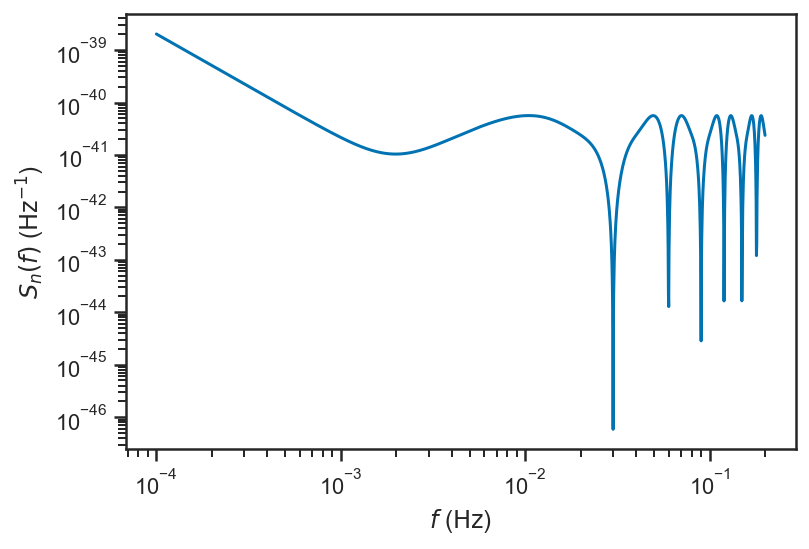

In [4]:
fs = exp(linspace(log(1e-4), log(2e-1), 2048))
loglog(fs, Sn(fs))
xlabel(r'$f$ ($\mathrm{Hz}$)')
ylabel(r'$S_n(f)$ ($\mathrm{Hz}^{-1}$)')

In [5]:
def constellation(ts, e=0.00985, R=1, kappa=0, lam=0):
    ts = torch.as_tensor(ts)
    
    L = 5e9*2*sqrt(3)*e*R # m ; R in AU
    
    alpha = 2*pi*ts/(3600.0*24.0*365.25*R**(3.0/2.0)) + kappa
    alpha = torch.reshape(alpha, (-1, alpha.shape[0]))
    
    betas = torch.as_tensor([kappa, kappa + 2*pi/3, kappa + 4*pi/3])
    betas = torch.reshape(betas, (betas.shape[0], -1))
    
    xs = R*torch.cos(alpha) + 0.5*e*R*(torch.cos(2*alpha - betas) - 3*torch.cos(betas))
    ys = R*torch.sin(alpha) + 0.5*e*R*(torch.sin(2*alpha - betas) - 3*torch.sin(betas))
    zs = -sqrt(3)*e*R*torch.cos(alpha - betas)
    
    return (xs, ys, zs)

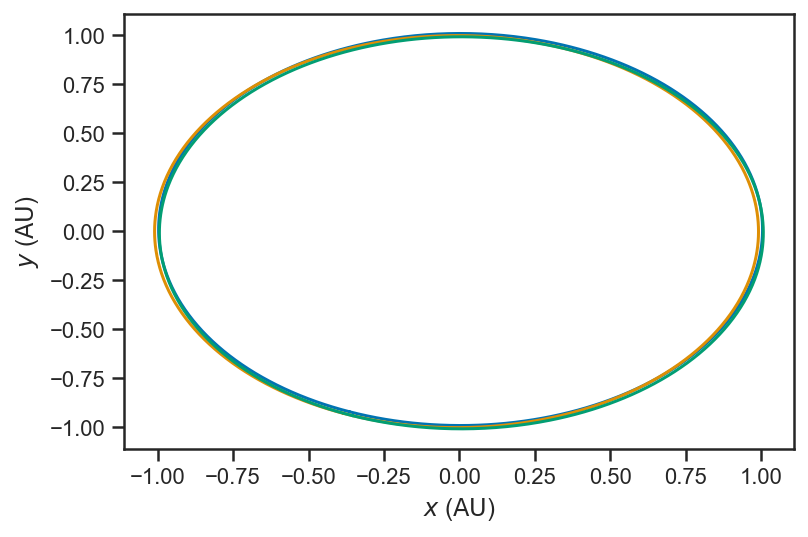

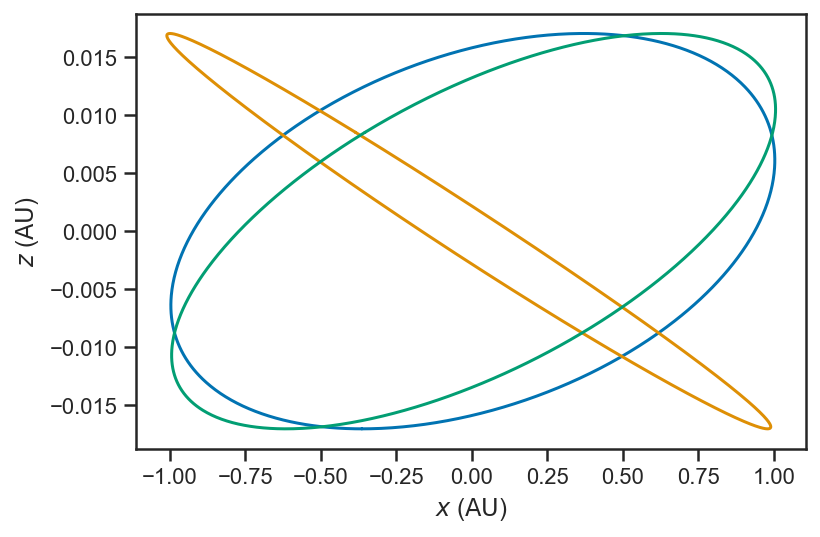

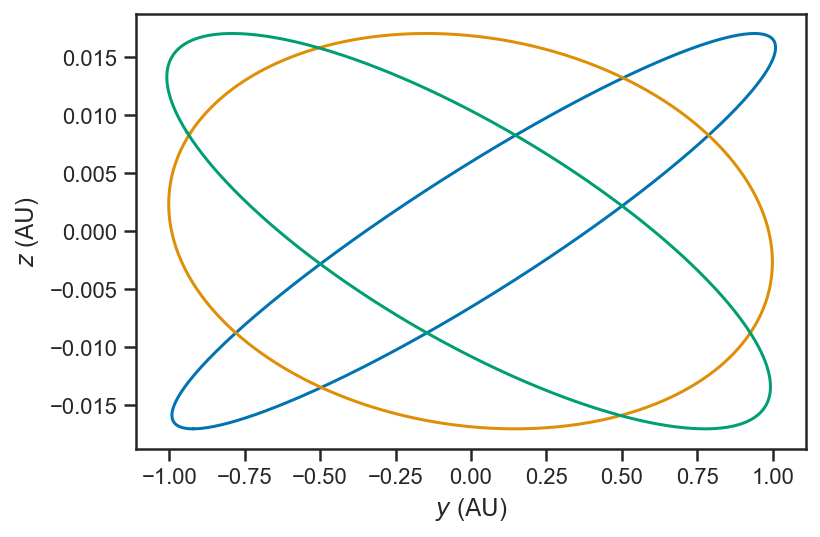

In [6]:
ts = linspace(0, 3600*24*365.25, 1024)
x,y,z = constellation(ts, lam=2*pi*rand(), kappa=2*pi*rand())
for i in range(3):
    plot(x[i,:], y[i,:])
    xlabel(r'$x$ ($\mathrm{AU}$)')
    ylabel(r'$y$ ($\mathrm{AU}$)')
figure()
for i in range(3):
    plot(x[i,:], z[i,:])
    xlabel(r'$x$ ($\mathrm{AU}$)')
    ylabel(r'$z$ ($\mathrm{AU}$)')
figure()
for i in range(3):
    plot(y[i,:], z[i,:])
    xlabel(r'$y$ ($\mathrm{AU}$)')
    ylabel(r'$z$ ($\mathrm{AU}$)')

In [7]:
def uvk(nhat):
    nhat = torch.as_tensor(nhat)
    phi = torch.atan2(nhat[1], nhat[0])
    cos_theta = nhat[2]
    sin_theta = torch.sqrt(1 - cos_theta*cos_theta)
    
    cphi = torch.cos(phi)
    sphi = torch.sin(phi)
    
    u = torch.as_tensor([cos_theta*cphi, cos_theta*sphi, -sin_theta])
    v = torch.as_tensor([sphi, -cphi, 0.0])
    k = torch.as_tensor([-sin_theta*cphi, -sin_theta*sphi, -cos_theta])
    
    return (u,v,k)

In [8]:
def ij_pairs():
    return [(0,1), (1,2), (2,0)]

def xyz_to_rij(x, y, z, i, j):
    return torch.stack([x[i,:]-x[j,:],
                        y[i,:]-y[j,:],
                        z[i,:]-z[j,:]])

In [9]:
def transfer(fs, ts, khat, xyz, L=5e9):
    fs = torch.as_tensor(fs)
    ts = torch.as_tensor(ts)
    khat = torch.as_tensor(khat)
    
    khat = torch.reshape(khat, (3, 1))
    
    x,y,z = xyz
    x = torch.as_tensor(x)
    y = torch.as_tensor(y)
    z = torch.as_tensor(z)
        
    fstar = 2.99792e8 / (2*pi*L)
    
    tfs = []
    for i,j in ij_pairs():
        rij = xyz_to_rij(x, y, z, i, j)
        
        rk = torch.sum(rij*khat, axis=0)
        w = fs/(2*fstar)*(1-rk)
        sc = torch.sin(w)/w
        
        tfs.append(sc*torch.exp(1j*w))
        
    return tfs

In [10]:
def dp_dc(xyz, uvk):
    x,y,z = xyz
    u,v,k = uvk

    x = torch.as_tensor(x)
    y = torch.as_tensor(y)
    z = torch.as_tensor(z)
    
    u = torch.as_tensor(u)
    v = torch.as_tensor(v)
    k = torch.as_tensor(k)
    
    dps = []
    dcs = []
    for i,j in ij_pairs():
        rij = xyz_to_rij(x, y, z, i, j)
        r2 = torch.sum(rij*rij, axis=0)
        rij = rij / torch.reshape(torch.sqrt(r2), (1, r2.shape[0]))
        
        ru = torch.sum(rij*torch.reshape(u, (3, 1)), axis=0)
        rv = torch.sum(rij*torch.reshape(v, (3, 1)), axis=0)
        
        dps.append(ru*ru - rv*rv)
        dcs.append(ru*rv + ru*rv)
        
    return dps, dcs